In [65]:
import numpy as np
import pandas as pd
import nibabel as nib
import os
from collections import Counter
import radiomics
from radiomics import featureextractor
from nilearn.plotting import plot_anat, plot_img, plot_stat_map

#### look at the data

In [6]:
# read path

md_path = 'D:/49/analysis/03_mci_MD.nii'
fa_path = 'D:/49/analysis/03_mci_FA.nii'
roi_path = 'D:/49/analysis/roi/rois/rois.nii'


# load them as nifti image

fa_image = nib.load(fa_path)
md_image = nib.load(md_path)
roi_image = nib.load(roi_path)


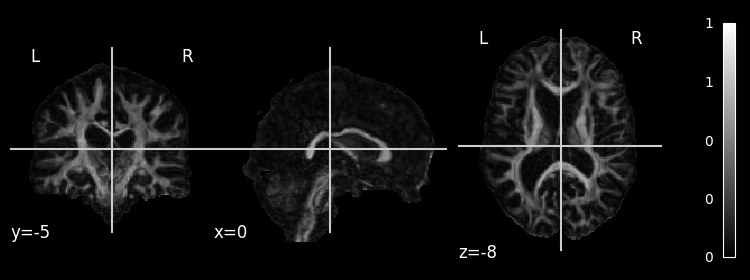

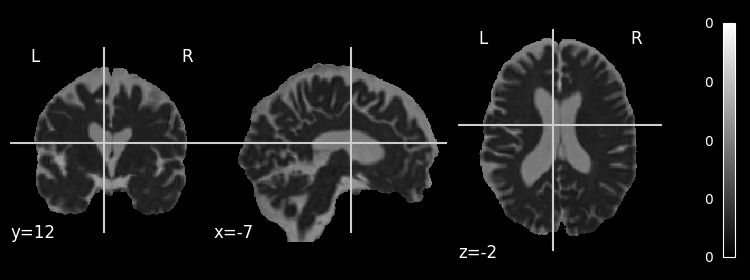

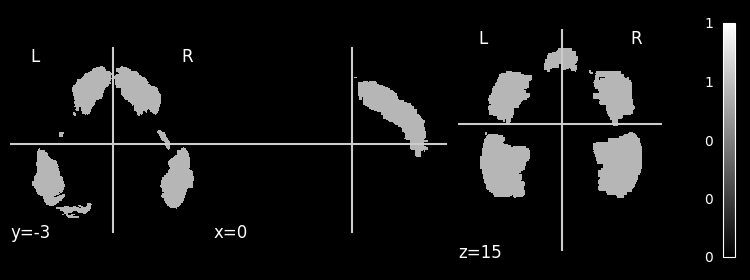

In [16]:
plot_anat(fa_image, colorbar=True, cbar_tick_format="%i")
plot_anat(md_image, colorbar=True, cbar_tick_format="%i")
plot_anat(roi_image, colorbar=True, cbar_tick_format="%i")

### Normalization and Segmentation 

In [19]:

def z_score_normalization(image):
    mean = np.mean(image)
    std = np.std(image)
    normalized_image = (image - mean) / std
    return normalized_image


def norm(image_path):
    img= nib.load(image_path)
    image_data = img.get_fdata()
    
    normalized_image_data = z_score_normalization(image_data)
    
    normalized_image = nib.Nifti1Image(normalized_image_data, img.affine,  header=img.header)
    
    return normalized_image

In [21]:
norm_fa = norm(fa_path)
norm_md = norm(md_path)

In [ ]:
# save normalized md, fa===> Z-score
nib.save(norm(md_path), '03_mci_MD_nrm.nii')
nib.save(norm(fa_path), '03_mci_FA_nrm.nii')


In [23]:
# segmentation

## get the data

In [27]:
fa_data = norm_fa.get_fdata()
md_data = norm_md.get_fdata()
roi_data = roi_image.get_fdata()
print("FA shape:", fa_data.shape)
print("MD shape:", md_data.shape)
print("ROI shape:", roi_data.shape)


FA shape: (182, 218, 182)
MD shape: (182, 218, 182)
ROI shape: (182, 218, 182)


In [29]:
roi_mask = roi_data > 0

segmented_fa = fa_data * roi_mask
segmented_md = md_data * roi_mask

segmented_fa_image = nib.Nifti1Image(segmented_fa, fa_image.affine, header=fa_image.header)
segmented_md_image = nib.Nifti1Image(segmented_md, md_image.affine, header=md_image.header)


In [ ]:
nib.save(segmented_fa_image, '03_mci_FA_nrm_segm.nii')
nib.save(segmented_md_image, '03_mci_MD_nrm_segm.nii')

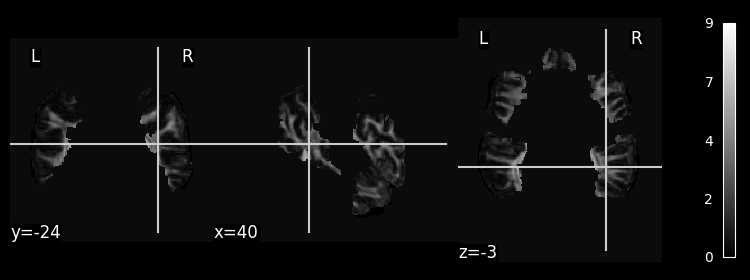

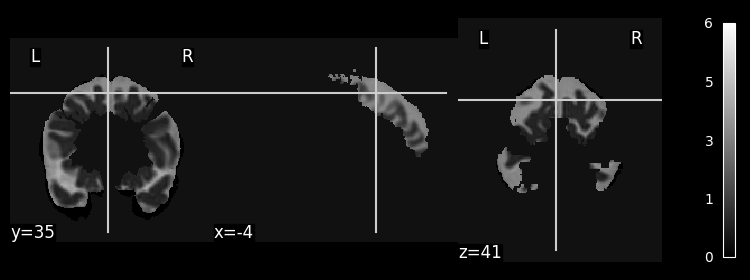

In [35]:
plot_anat(segmented_fa_image, colorbar=True, cbar_tick_format="%i")
plot_anat(segmented_md_image, colorbar=True, cbar_tick_format="%i")
#plot_anat(roi_image, colorbar=True, cbar_tick_format="%i")

#### remove black non brain area

In [38]:

segmented_fa_data = segmented_fa_image.get_fdata()
segmented_md_data = segmented_md_image.get_fdata()


fa_flat = segmented_fa_data.flatten()
md_flat = segmented_md_data.flatten()

fa_counts = Counter(fa_flat)
md_counts = Counter(md_flat)

most_common_fa_value = fa_counts.most_common(2)[1][0] if fa_counts.most_common(1)[0][0] == 0 else fa_counts.most_common(1)[0][0]
most_common_md_value = md_counts.most_common(2)[1][0] if md_counts.most_common(1)[0][0] == 0 else md_counts.most_common(1)[0][0]


fa_common_mask = segmented_fa_data == most_common_fa_value
md_common_mask = segmented_md_data == most_common_md_value

cleaned_fa_data = np.where(fa_common_mask, 0, segmented_fa_data)
cleaned_md_data = np.where(md_common_mask, 0, segmented_md_data)


cleaned_fa_image = nib.Nifti1Image(cleaned_fa_data, segmented_fa_image.affine,  header=segmented_fa_image.header)
cleaned_md_image = nib.Nifti1Image(cleaned_md_data, segmented_md_image.affine,  header=segmented_md_image.header)


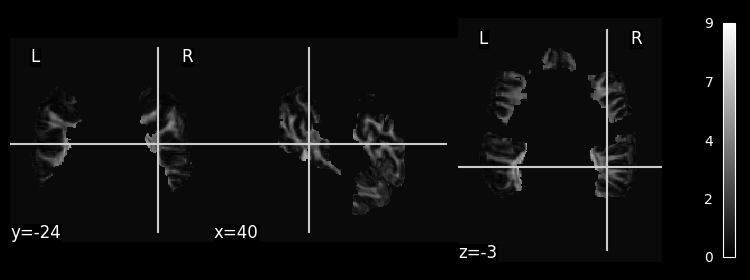

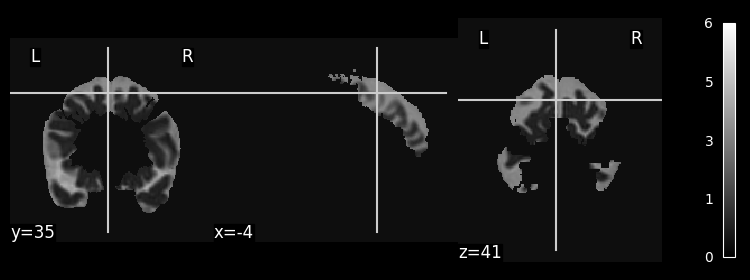

In [40]:
plot_anat(cleaned_fa_image, colorbar=True, cbar_tick_format="%i")
plot_anat(cleaned_md_image, colorbar=True, cbar_tick_format="%i")
#plot_anat(roi_image, colorbar=True, cbar_tick_format="%i")

In [ ]:
nib.save(cleaned_fa_image, '03_mci_FA_nrm_segm_final.nii')
nib.save(cleaned_md_image, '03_mci_MD_nrm_segm_final.nii')

### Radiomics

In [43]:
fa_image = cleaned_fa_image
md_image = cleaned_md_image

roi_mask = fa_image.get_fdata() != 0
roi_mask_image = nib.Nifti1Image(roi_mask.astype(np.uint8), fa_image.affine, header=fa_image.header)
#nib.save(roi_mask_image, 'roi_mask_image_fa.nii')


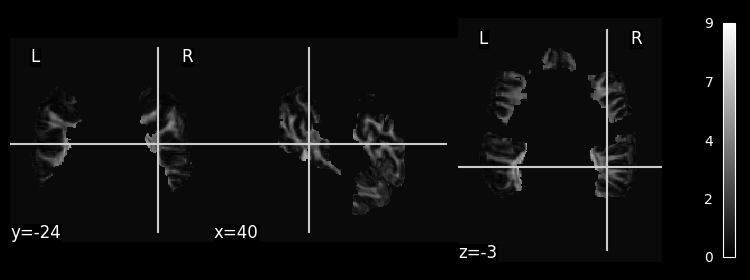

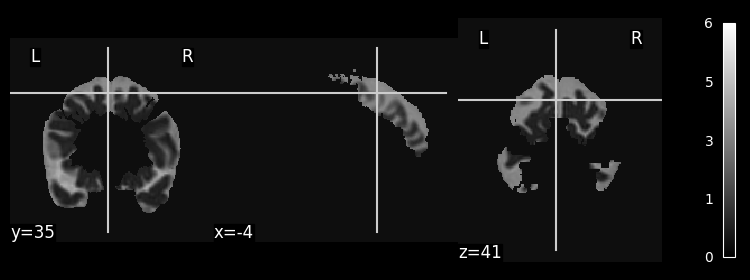

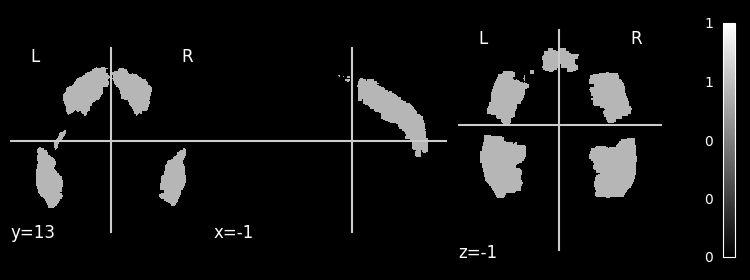

In [45]:
plot_anat(fa_image, colorbar=True, cbar_tick_format="%i")
plot_anat(md_image, colorbar=True, cbar_tick_format="%i")
plot_anat(roi_mask_image, colorbar=True, cbar_tick_format="%i")

In [53]:
fa_image_path = 'D:/49/analysis/03_mci_FA_nrm_segm_final.nii'
md_image_path = 'D:/49/analysis/03_mci_MD_nrm_segm_final.nii'
roi_mask_path = 'D:/49/analysis/roi_mask_image_fa.nii'
params = 'D:/49/analysis/radiomics_config.yml'
extractor = featureextractor.RadiomicsFeatureExtractor(params)


In [55]:
fa_features = extractor.execute(fa_image_path, roi_mask_path)
md_features = extractor.execute(md_image_path, roi_mask_path)

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


In [57]:
fa_features

OrderedDict([('diagnostics_Versions_PyRadiomics', 'v3.0.1'),
             ('diagnostics_Versions_Numpy', '1.26.4'),
             ('diagnostics_Versions_SimpleITK', '2.2.1'),
             ('diagnostics_Versions_PyWavelet', '1.5.0'),
             ('diagnostics_Versions_Python', '3.11.9'),
             ('diagnostics_Configuration_Settings',
              {'minimumROIDimensions': 2,
               'minimumROISize': None,
               'normalize': False,
               'normalizeScale': 1,
               'removeOutliers': None,
               'resampledPixelSpacing': None,
               'interpolator': 'sitkBSpline',
               'preCrop': False,
               'padDistance': 5,
               'distances': [1],
               'force2D': False,
               'force2Ddimension': 0,
               'resegmentRange': None,
               'label': 1,
               'additionalInfo': True}),
             ('diagnostics_Configuration_EnabledImageTypes', {'Original': {}}),
             ('diagn

In [71]:
fa_df = pd.DataFrame(list(fa_features.items()), columns=['Feature', 'Value'])
md_df = pd.DataFrame(list(md_features.items()), columns=['Feature', 'Value'])


In [69]:
fa_df

,Feature,Value
0,diagnostics_Versions_PyRadiomics,v3.0.1
1,diagnostics_Versions_Numpy,1.26.4
2,diagnostics_Versions_SimpleITK,2.2.1
3,diagnostics_Versions_PyWavelet,1.5.0
4,diagnostics_Versions_Python,3.11.9
...,...,...
124,original_ngtdm_Busyness,11945.923011961244
125,original_ngtdm_Coarseness,2.6888005850935405e-05
126,original_ngtdm_Complexity,0.12968447926312235
127,original_ngtdm_Contrast,0.016244755827884063


In [73]:

# Save the DataFrames to CSV files
fa_df.to_csv('fa_features.csv', index=False)
md_df.to_csv('md_features.csv', index=False)
